In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

In [56]:
asr = pd.read_csv('../data/asr_grouped_by_yr_w_fips.csv', dtype={'fipscd': str})

In [69]:
asr['any_ev'] = (asr['ev_count'] > 0).astype(int)
asr['any_ev_07'] = (asr['ev_count_post_07'] > 0).astype(int)
asr['pre_1980'] = (asr['year_built_max'] < 1980)
asr['built_1980'] = None
asr.loc[asr['pre_1980'], 'built_1980'] = 'before'
asr.loc[~asr['pre_1980'], 'built_1980'] = 'after'
asr['ev_per_unit'] = asr['ev_count'] / asr['total_units']
asr['ev_per_unit_since_07'] = asr['ev_count_post_07'] / asr['total_units']

In [85]:
ev = pd.read_csv('../data/ev_matched_w_fips.csv')
print(ev.shape)

(47720, 26)


/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
ev = ev.merge(asr, left_on='asr_index', right_on='index', suffixes=('_ev', '_asr'))
print(ev.shape)

(45273, 53)


In [87]:
ev = ev[(ev['any_rc_eligibility'] == 1) & (ev['total_units'] > 0)]
print(ev.shape)

(29749, 53)


#### Table 1

In [89]:
ev.loc[pd.isnull(ev['type']), 'type'] = 'unknown'
type_counts = ev.groupby(['built_1980', 'type']).agg(count=('index_ev', 'nunique')).reset_index()
pre_sums = type_counts.groupby('built_1980')['count'].sum()

ev['ev_type_cat'] = 'breach of lease'
ev.loc[ev['type'].isin([
    'OMI', 'Capital Improvement', 'ELLIS', 'Condo Conversion', 'Substantial Rehabilitation',
    'Lead Remediation', 'Good Samaritan Tenancy Ends',
    'Development Agreement', 'Demolition']), 'ev_type_cat'] = 'no fault'
ev.loc[ev['type'].isin(['unknown', 'Other']), 'ev_type_cat'] = 'unknown/Other'

In [90]:
cat_counts = ev.groupby(['built_1980', 'ev_type_cat']).agg(count=('index_ev', 'nunique')).reset_index()
cat_counts = cat_counts.pivot(index='ev_type_cat', columns='built_1980', values='count')
cat_counts['pct_after'] = cat_counts['after'] / pre_sums['after']
cat_counts['pct_before'] = cat_counts['before'] / pre_sums['before']
cat_counts

built_1980,after,before,pct_after,pct_before
ev_type_cat,,,,
breach of lease,211,12239,0.522277,0.417073
no fault,48,6848,0.118812,0.233362
unknown/Other,145,10258,0.358911,0.349566


#### Table 2

In [77]:
mean_diffs = asr[
    (asr['total_units'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
        total_addresses=('index', 'count'),
        total_units=('total_units', 'sum'),
        mean_units_per_address=('total_units','mean'),
        total_evictions=('ev_count', 'sum'),
        mean_any_ev=('any_ev', 'mean'),
        mean_ev_per_address=('ev_count','mean'),
        mean_ev_per_unit=('ev_per_unit','mean'),





)

# mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
# mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
# mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

total_addresses  total_units  \
any_rc_eligibility pre_1980                                 
0.0                False               76864       364153   
                   True              1120987      1588711   
1.0                False               15645       134008   
                   True               362735      1770103   

                             mean_units_per_address  total_evictions  \
any_rc_eligibility pre_1980                                            
0.0                False                   4.737627              485   
                   True                    1.417243            12308   
1.0                False                   8.565548              404   
                   True                    4.879879            29345   

                             mean_any_ev  mean_ev_per_address  \
any_rc_eligibility pre_1980                                     
0.0                False        0.004215             0.006310   
                   True         0.006608             0.010980   
1.0                False        0.014062             0.025823   
                   True         0.036341             0.080899   

                             mean_ev_per_unit  
any_rc_eligibility pre_1980                    
0.0                False             0.003296  
                   True              0.008609  
1.0                False             0.009969  
                   True              0.023403

In [88]:
362735 + 15645

378380

#### Fig 1

In [75]:
rc_pop = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1953) &
    (asr['year_built_max'] < 2007) & (asr['total_units'] > 0)]

yr_vs_ev = rc_pop.groupby('year_built_max').agg({
    'ev_per_unit': 'mean',
}).reset_index()

yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                     (yr_vs_ev['year_built_max'] >= 1953)]
yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                     (yr_vs_ev['year_built_max'] <= 2007)]

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.3, 0.8, 'rent control \nbuilt-year threshold')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  func(*args, **kwargs)
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  fig.canvas.print_figure(bytes_io, **kw)


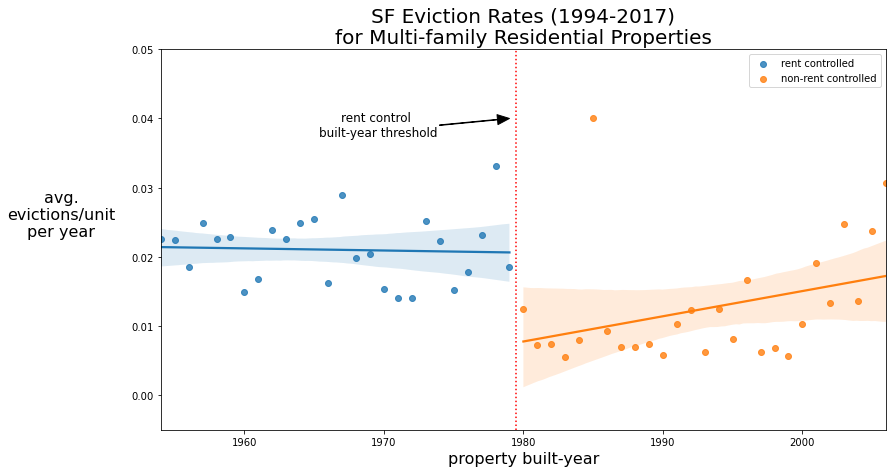

In [76]:
fig, ax = plt.subplots(figsize=(13,7))
sns.regplot('year_built_max', 'ev_per_unit', yr_vs_ev1, ax=ax, truncate=True, label='rent controlled')
sns.regplot('year_built_max', 'ev_per_unit', yr_vs_ev2, ax=ax, truncate=True, label='non-rent controlled')
ax.axvline(1979.5, ls=':', c='r')
ax.legend()
_ = ax.set_xlabel("property built-year", fontsize=16)
_ = ax.set_ylabel("avg.\nevictions/unit\nper year", fontsize=16, rotation=0, labelpad=70)
_ = ax.set_title("SF Eviction Rates (1994-2017)\nfor Multi-family Residential Properties", fontsize=20)
ax.set_ylim((-0.005, 0.05))
ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
            xytext=(0.3, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',frac=0.05, width=0.5, headwidth=10),
            horizontalalignment='center', verticalalignment='center', fontsize=12
            )